# hetan: ridge regression on macro variables and a basket of related stocks is what i’d suggest

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas_datareader as pdr
import quantstats as qs
import pytz

import datetime as dt

from sklearn import linear_model

In [3]:
snp_data = pd.read_csv('../Data/Structured_Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()

In [4]:
pd.__version__

'1.4.3'

# Try Hetan's suggestion - rough generalization of pairs trading on multiple assets

In [5]:
# tickerName: string, a single ticker
# period can be '_mo', '_
def downloadClosingPrices(tickerName, period='6mo'):
    return yf.Ticker(tickerName).history(period=period)[['Close']]

# closingPrices: a Pandas Dataframe of closing prices
# returns a list of returns
def getReturns(closingPrices):
    return closingPrices.pct_change(1).dropna() #closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))

# tickerNames: a list of strings of ticker names
# returns a dictionary of ticker names to lists of their daily returns
def makeDailyReturnsDf(tickerNames, period='6mo'):
    ticker_data = {}
  
    longestIndex = pd.Series(dtype='float64')
    # retrieve data
    for t in tickerNames:
        # take over the past 6 months
        c = downloadClosingPrices(t, period)
        # store longest index
        if len(c.index) >= len(longestIndex):
            longestIndex = c.index[1:]
        # No data found, symbol may be delisted
        if len(c) == 0:
            continue
        else:
            ticker_data[t] = getReturns(c).rename(columns={"Close":t}).squeeze().tolist()
    # remove stocks which are not of the same length
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    # ticker_data
    return pd.DataFrame(ticker_data, index = longestIndex)

# tickersToPredict DOESN'T have to be a subset of tickers
# returns a dictionary with the name of the stock as keys and the LM predicting that stock as values
# trains pair-wise LMs using same-day returns of related stocks as predictors
def trainLM(tickers, tickerToPredict):

    X = makeDailyReturnsDf(tickers)
    y = makeDailyReturnsDf([tickerToPredict])

    lm = Ridge()
    if tickerToPredict in X.columns:
        X.drop(columns=tickerToPredict, inplace=True)
    lm.fit(X, y)
    print(tickerToPredict, lm.score(X, y))
    return lm

In [6]:
# TODO: change to return series?
## zscore fn to generate buy/sell signals on a daily basis
# takes the zscore of a particular day's prediction over a window of past days
# lm: the linear model predicting stock returns based on related stocks
# X: a dataframe of predictors - returns of stocks related to the target
# y: a list of the target stock's returns
# days: number of days back to scale over
def zscore(lm, X, y, days=30):
    # lookback = min(len(X), len(y), days)
    lookback = days
    # print('lookback',lookback)
    steps = len(X)
    z_ts = []
    for s in range(steps,lookback,-1):
        X_window, y_window = X.iloc[s-lookback:s,], y.iloc[s-lookback:s]
        # predict for the last lookback no. of days
        y_hats = lm.predict(X_window)
        # get the residuals
        y_res = y_window - y_hats

        # get residual for today
        y_res_t = y_res.iloc[-1]
        y_res_ex_t = y_res.iloc[:-1]

        scaler = StandardScaler()
        # fit scale based on residuals up to yesterday
        scaler.fit(np.asarray(y_res_ex_t).reshape(-1,1))

        # transform today's residual
        z_t = scaler.transform(np.asarray(y_res_t).reshape(-1,1))
        z_ts.append(z_t[0][0])
    return z_ts

## Make Rolling Regression model (without sentiment)

In [7]:
spy = makeDailyReturnsDf(["SPY"], '4y')
spy

,SPY
Date,
2018-11-09 00:00:00-05:00,-0.009768
2018-11-12 00:00:00-05:00,-0.018685
2018-11-13 00:00:00-05:00,-0.001871
2018-11-14 00:00:00-05:00,-0.006837
2018-11-15 00:00:00-05:00,0.010437
...,...
2022-11-01 00:00:00-04:00,-0.004376
2022-11-02 00:00:00-04:00,-0.025096
2022-11-03 00:00:00-04:00,-0.010297


In [8]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def Model(tickers_to_predict, tickers_as_predictors, window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        Xhist = makeDailyReturnsDf([t for t in tickers_as_predictors if t != tick], '4y')
        yhist = makeDailyReturnsDf([tick],'4y')
        Xyhist = pd.concat([Xhist, yhist], axis=1)
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = retsSpreads['Date'].dt.tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

# Compile lists of relevant stocks

In [9]:
snp_data[:10]

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value,Action
0,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,396,557,976,700",0.60%,21.67,6.21,32.78,Analyze
1,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$1,700,887,137,266",1.08%,22.04,8.83,9.80,Analyze
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.82,4.04,2.00,Analyze
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.69,4.04,1.96,Analyze
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$987,418,107,695",0.00%,42.54,2.07,6.80,Analyze
5,TSLA,Tesla Inc,Common stocks,Large cap,Consumer Discretionary,"$713,867,145,652",0.00%,80.33,11.48,19.79,Analyze
6,BRK.B,Berkshire Hathaway Inc. Class B,Common stocks,Large cap,Financials,"$648,469,030,904",0.00%,4.42,1.83,0.71,Analyze
7,UNH,Unitedhealth Group Inc,Common stocks,Large cap,Health Care,"$511,944,311,010",1.13%,29.14,1.73,6.99,Analyze
8,XOM,Exxon Mobil Corp,Common stocks,Large cap,Energy,"$466,400,177,773",3.10%,17.95,1.52,2.74,Analyze
9,JNJ,Johnson & Johnson,Common stocks,Large cap,Health Care,"$452,540,967,536",2.51%,22.51,4.77,5.97,Analyze


Some of the top tech stocks like Google are classified as "Communication Services", so we include those

In [10]:
top20_it_stocks = snp_data[snp_data['GICS Sector'] == 'Information Technology']['Symbol'].to_list()[:20]
top20_stocks = snp_data['Symbol'].to_list()[:20]
top20_comm_stocks = snp_data[snp_data['GICS Sector']=='Communication Services']['Symbol'].to_list()[:20]
top20_it_comm_stocks = snp_data[snp_data['GICS Sector'].isin(['Information Technology', 'Communication Services'])]['Symbol'].to_list()[:20]

In [11]:
top20_it_comm_stocks

['AAPL',
 'MSFT',
 'GOOG',
 'GOOGL',
 'V',
 'NVDA',
 'MA',
 'META',
 'ORCL',
 'DIS',
 'AVGO',
 'TMUS',
 'ACN',
 'CSCO',
 'CRM',
 'VZ',
 'TXN',
 'ADBE',
 'CMCSA',
 'QCOM']

100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

ols.rsquared Date
2018-11-09 00:00:00-05:00    NaN
2018-11-12 00:00:00-05:00    NaN
2018-11-13 00:00:00-05:00    NaN
2018-11-14 00:00:00-05:00    NaN
2018-11-15 00:00:00-05:00    NaN
                            ... 
2022-11-01 00:00:00-04:00    1.0
2022-11-02 00:00:00-04:00    1.0
2022-11-03 00:00:00-04:00    1.0
2022-11-04 00:00:00-04:00    1.0
2022-11-07 00:00:00-05:00    1.0
Length: 1005, dtype: float64


                           Strategy
-------------------------  ----------
Start Period               2019-05-06
End Period                 2022-11-07
Risk-Free Rate             2.0%
Time in Market             100.0%

Cumulative Return          176.18%
CAGR﹪                     33.57%

Sharpe                     0.95
Prob. Sharpe Ratio         90.06%
Smart Sharpe               0.81
Sortino                    1.39
Smart Sortino              1.19
Sortino/√2                 0.98
Smart Sortino/√2           0.84
Omega                      1.18

Max Drawdown               -31.43%
Longest DD Days            307
Volatility (ann.)          34.78%
Calmar                     1.07
Skew                       -0.03
Kurtosis                   4.45

Expected Daily %           0.11%
Expected Monthly %         2.39%
Expected Yearly %          28.91%
Kelly Criterion            8.5%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.46%
Expected Shortfall (cVaR)  -3.46%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-13,2020-03-23,2020-06-05,113,-31.426446,-29.938074
2,2022-01-04,2022-09-30,2022-11-07,307,-27.949053,-27.542394
3,2020-09-02,2020-09-18,2020-12-28,117,-20.375157,-20.166479
4,2021-01-27,2021-03-08,2021-07-07,161,-18.598508,-16.066141
5,2019-05-07,2019-06-03,2019-07-23,77,-16.553895,-15.701667


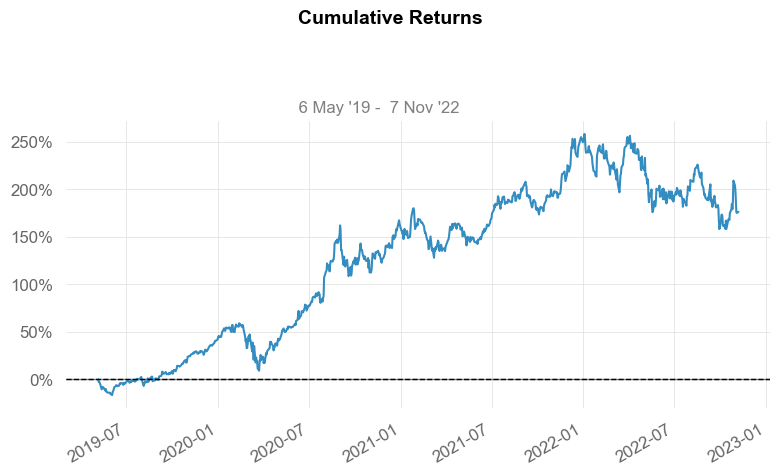

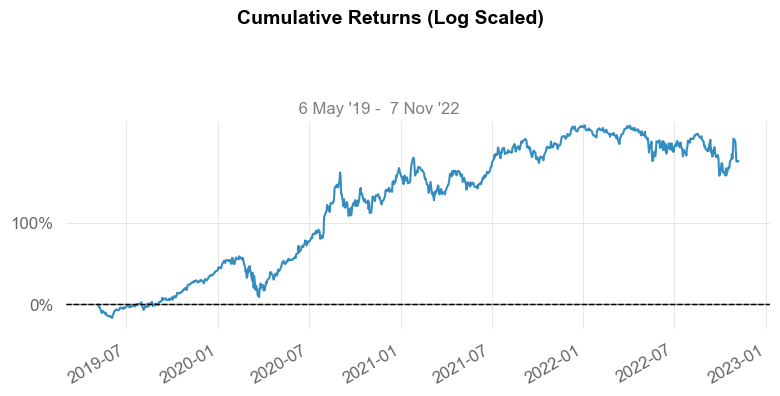

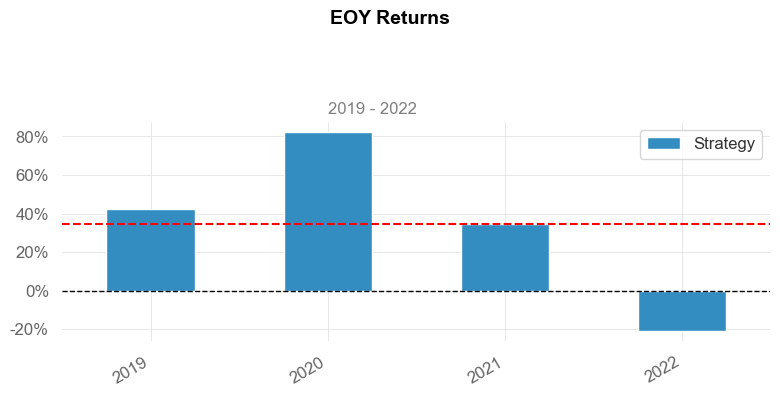

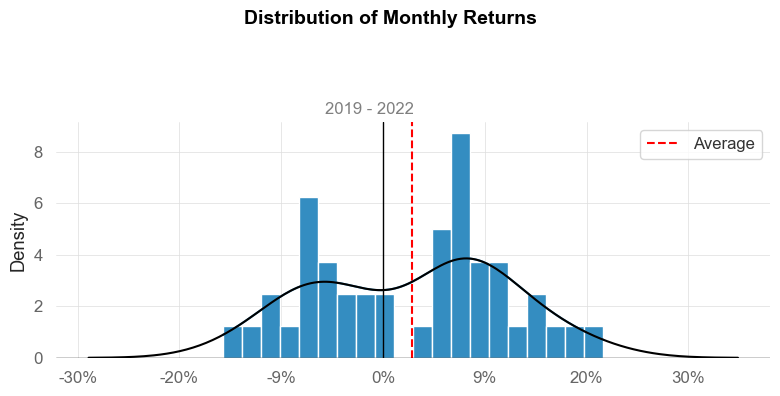

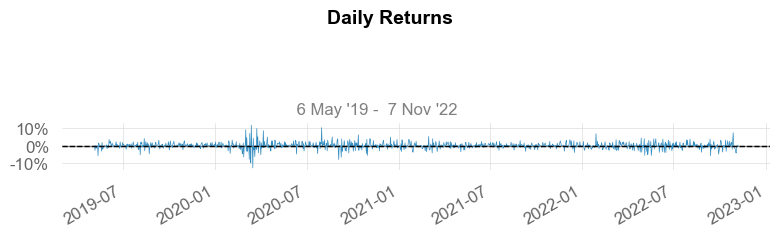

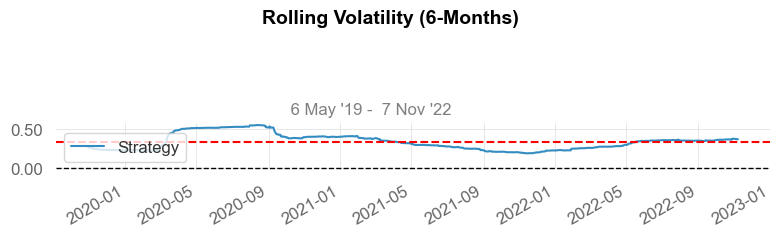

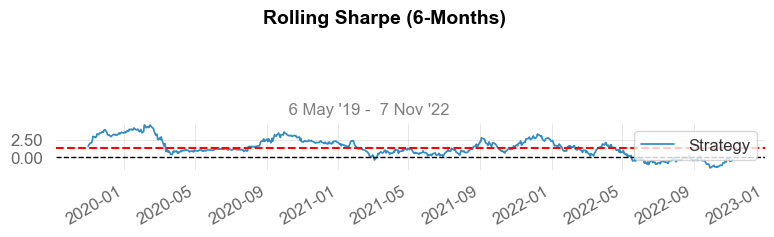

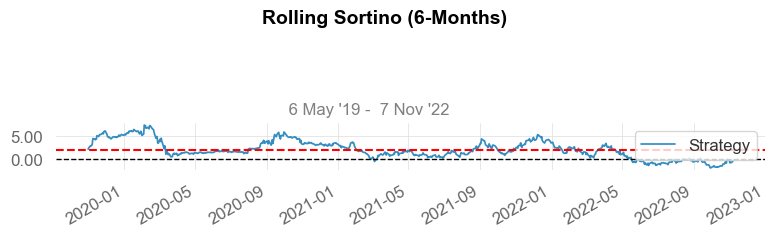

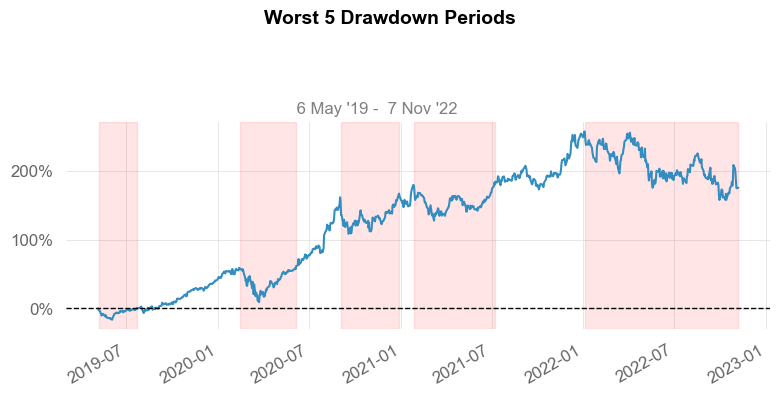

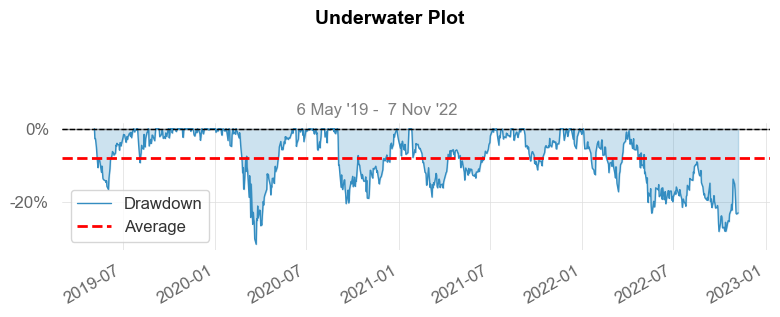

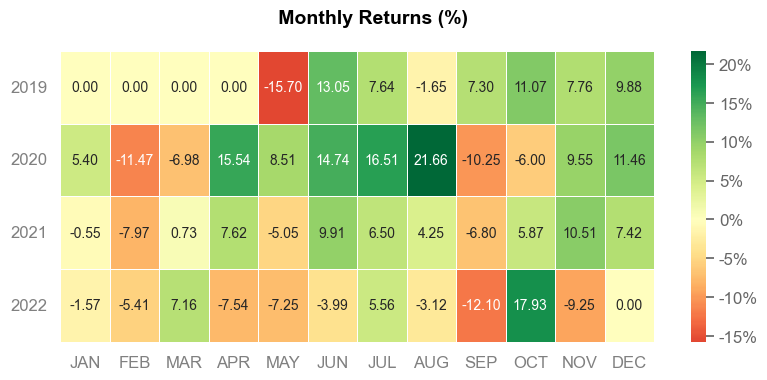

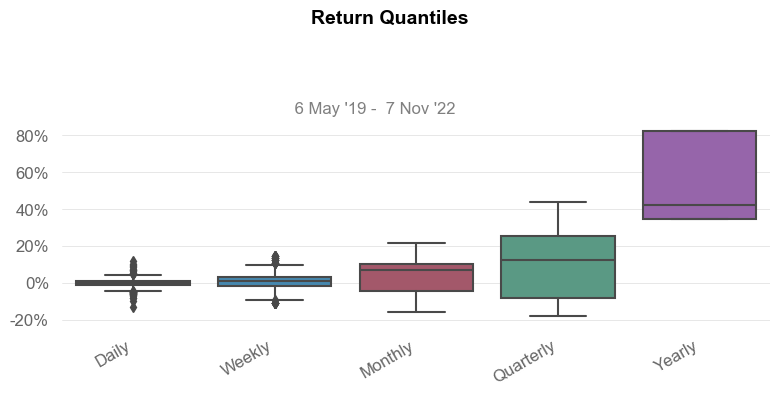

In [12]:
Model(['AAPl'], top20_it_comm_stocks)

# Try Model with incorporation of sentiment

cache returns data into csvs so that we don't get the newest data from dynamic calls to yahoo finance. This allows us to match the dates with those from the predictions from the sentiment analyses techniques which are also not dynamic and stored in csvs.

In [13]:
top20_it_stocks_df = makeDailyReturnsDf(top20_it_stocks, '1y')
top20_it_stocks_df.to_csv('../Data/Structured_Data/top20_it_stocks.csv')
top20_it_comm_stocks_df = makeDailyReturnsDf(top20_it_comm_stocks, '1y')
top20_it_comm_stocks_df.to_csv('../Data/Structured_Data/top20_it_comm_stocks.csv')

In [14]:
AAPL = makeDailyReturnsDf(['AAPL'], '1y')
AAPL.to_csv('../Data/Structured_Data/AAPL.csv')
TSLA = makeDailyReturnsDf(['TSLA'], '1y')
TSLA.to_csv('../Data/Structured_Data/TSLA.csv')
META = makeDailyReturnsDf(['META'], '1y')
META.to_csv('../Data/Structured_Data/META.csv')

In [15]:
def readDailyReturnsFromCsv(tickerNames, period='6mo', filepath='../Data/Structured_Data/'):
    ticker_data = {}
    longestIndex = pd.Series(dtype='float64')
    for t in tickerNames:
        df = pd.read_csv(filepath+t+'.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index, utc=True).date
        df.index.rename('Date', inplace=True)
        ticker_data[t] = df
        if df.shape[0] >= len(longestIndex):
            longestIndex = df.index[1:]
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    combined = pd.concat(list(ticker_data.values()))
    return combined
    

In [16]:
combined = readDailyReturnsFromCsv(['TSLA'])
combined.drop(columns=['TSLA'], inplace=True)
combined

""
Date
2021-11-09
2021-11-10
2021-11-11
2021-11-12
2021-11-15
...
2022-11-01
2022-11-02
2022-11-03


In [17]:
readDailyReturnsFromCsv(['TSLA',])

,TSLA
Date,
2021-11-09,-0.119903
2021-11-10,0.043429
2021-11-11,-0.004158
2021-11-12,-0.028293
2021-11-15,-0.019382
...,...
2022-11-01,0.001231
2022-11-02,-0.056360
2022-11-03,0.001535


In [19]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def ModelwSentiment(tickers_to_predict=['AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        #TODO: read from csv file instead of pulling live data to match the sentiment predictions by Elton
        # yhist = pd.read_csv('../Data/Structured_Data/aapl.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
        yhist = readDailyReturnsFromCsv([tick])
        yhist.index = pd.to_datetime(yhist.index, utc=True).date
        yhist.index.rename('Date', inplace=True)


        # returns data
        # Xhist_rets = pd.read_csv('../Data/Structured_Data/top20_it_comm_stocks_df.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
        Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
        if tick in Xhist_rets.columns:
            Xhist_rets.drop(columns=tick, inplace=True)
        Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
        Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        # print('Xhist.shape', Xhist.shape)
        # print('yhist.shape', yhist.shape)
        # print('Xyhist.shape', Xyhist.shape)
        # get betas
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                #TODO: add sentiment here
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        # get weights
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                #TODO: add sentiment here
                # spread is the residuals
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        # drop predicted sentiment data as tradeable stock
        betas.drop(columns=tickers_to_predict, inplace=True)
        weights.drop(columns=tickers_to_predict, inplace=True)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()
    print(retsSpreads)

    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1295/3930470958.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.833660
2022-08-26    0.843686
2022-08-29    0.843779
2022-08-30    0.841206
2022-08-31    0.844212
Length: 172, dtype: float64
          Date         0
0   2022-06-16  0.000000
1   2022-06-17  0.001713
2   2022-06-21  0.008690
3   2022-06-22 -0.001298
4   2022-06-23  0.001920
5   2022-06-24  0.009065
6   2022-06-27 -0.003219
7   2022-06-28 -0.005395
8   2022-06-29 -0.000179
9   2022-06-30 -0.004247
10  2022-07-01  0.001498
11  2022-07-05  0.001940
12  2022-07-06  0.002058
13  2022-07-07  0.004882
14  2022-07-08 -0.000914
15  2022-07-11 -0.003280
16  2022-07-12 -0.004285
17  2022-07-13 -0.001555
18  2022-07-14 -0.000148
19  2022-07-15  0.005396
20  2022-07-18 -0.003835
21  2022-07-19  0.010655
22  2022-07-20  0.001535
23  2022-07-21  0.001163
24  2022-07-22 -0.010927
25  2022-07-25 -0.000594
26  2022-07-26 -0.005506
2

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          0.71%
CAGR﹪                     3.44%

Sharpe                     0.22
Prob. Sharpe Ratio         53.33%
Smart Sharpe               0.22
Sortino                    0.34
Smart Sortino              0.34
Sortino/√2                 0.24
Smart Sortino/√2           0.24
Omega                      1.04

Max Drawdown               -2.79%
Longest DD Days            23
Volatility (ann.)          7.19%
Calmar                     1.23
Skew                       0.31
Kurtosis                   0.54

Expected Daily %           0.01%
Expected Monthly %         0.23%
Expected Yearly %          0.71%
Kelly Criterion            3.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.73%
Expected Shortfall (cVaR)  -0.73%

Max Consecutive Wins       4
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-2.792545,-2.606079
2,2022-07-22,2022-07-26,2022-08-01,10,-1.695768,-1.151528
3,2022-06-27,2022-06-30,2022-07-20,23,-1.298351,-1.282189
4,2022-08-05,2022-08-09,2022-08-10,5,-0.410662,-0.260892
5,2022-08-02,2022-08-02,2022-08-03,1,-0.347287,0.000000


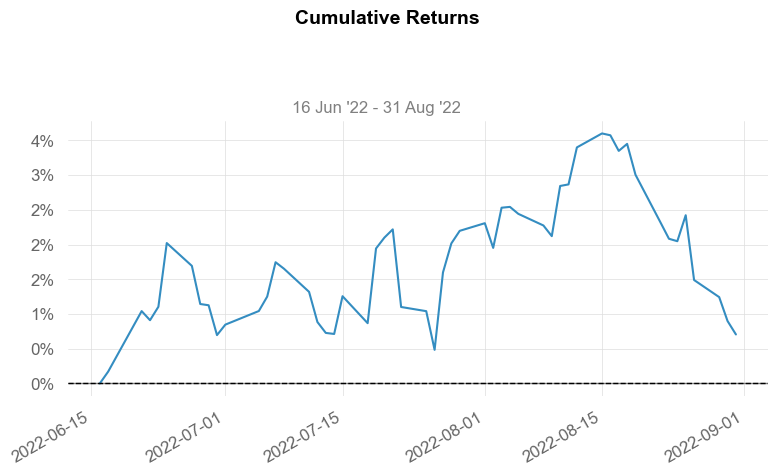

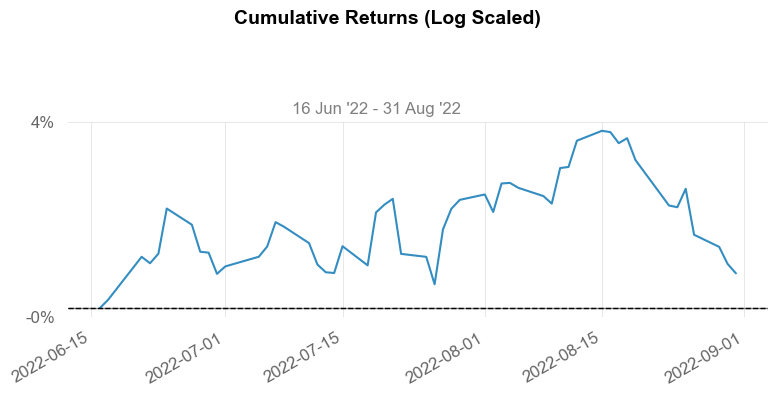

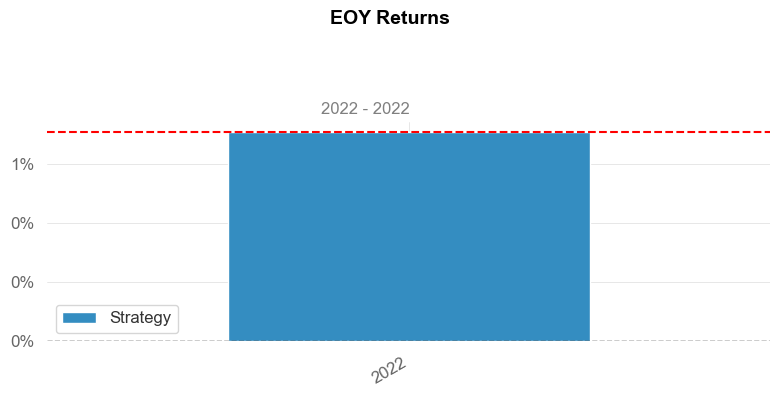

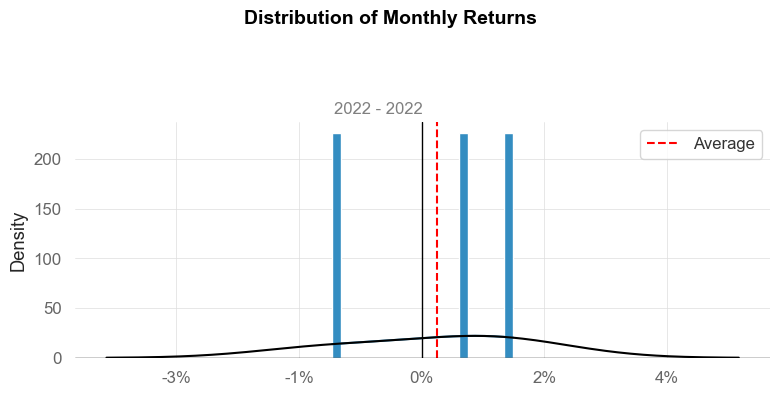

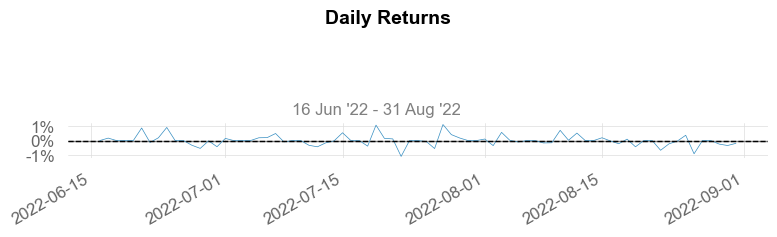

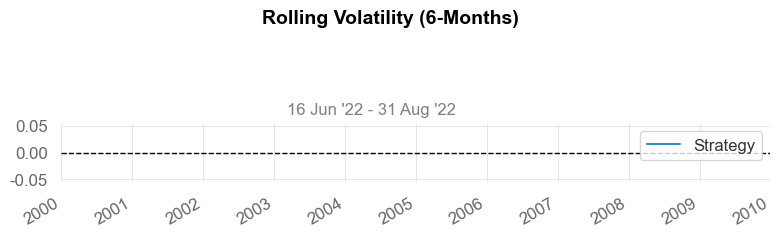

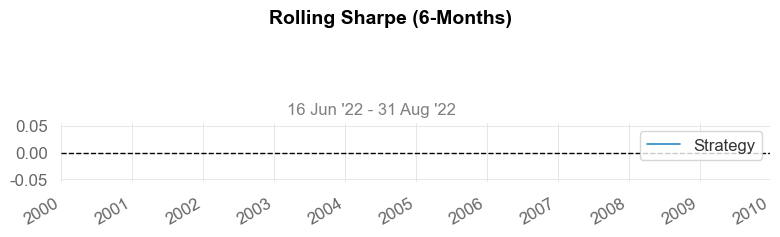

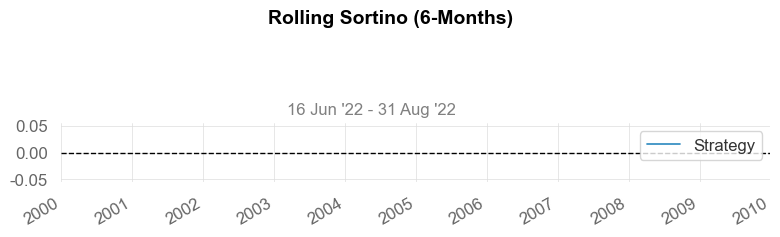

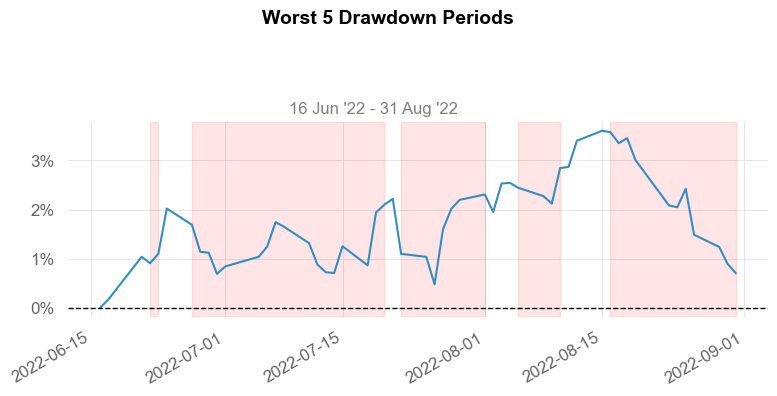

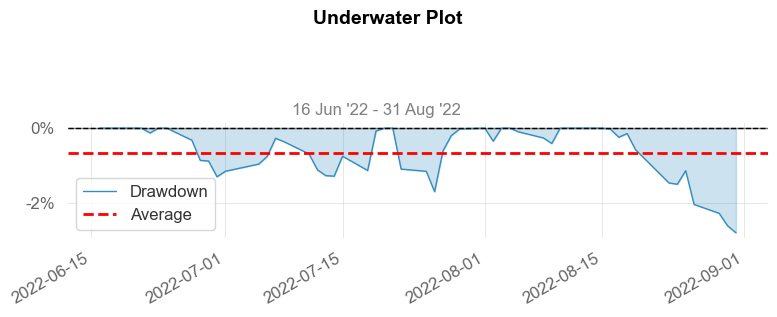

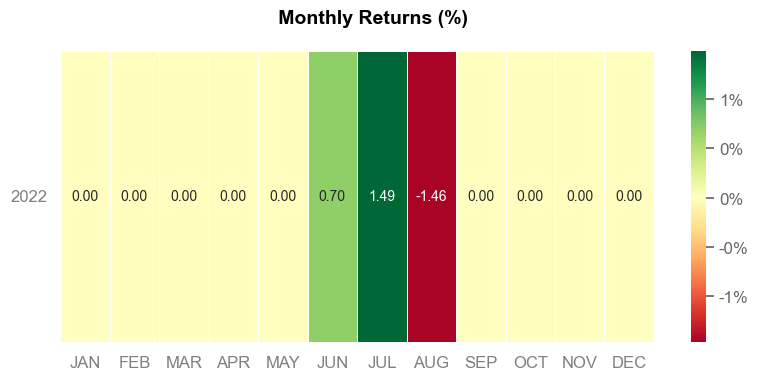

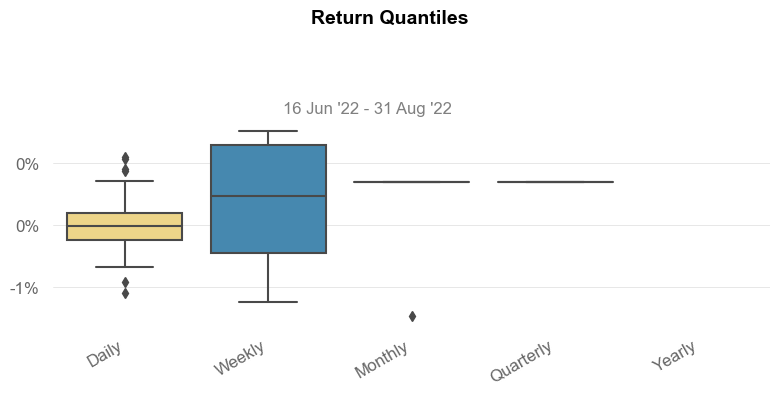

In [20]:
ModelwSentiment()

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1118/2588586244.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

Xhist_rets
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM'],
      dtype='object')
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM'],
      dtype='object')
initial weights
Index(['TSLA', 'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META',
       'ORCL', 'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN',
       'ADBE', 'CMCSA', 'QCOM', 'TSLA'],
      dtype='object')
betas.columns
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM', 'TSLA'],
      dtype='object')
betas.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM',

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.54%
CAGR﹪                     12.83%

Sharpe                     2.02
Prob. Sharpe Ratio         82.49%
Smart Sharpe               1.89
Sortino                    3.1
Smart Sortino              2.89
Sortino/√2                 2.19
Smart Sortino/√2           2.04
Omega                      1.39

Max Drawdown               -1.37%
Longest DD Days            15
Volatility (ann.)          4.99%
Calmar                     9.39
Skew                       -0.31
Kurtosis                   0.17

Expected Daily %           0.05%
Expected Monthly %         0.84%
Expected Yearly %          2.54%
Kelly Criterion            17.57%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.47%
Expected Shortfall (cVaR)  -0.47%

Max Consecutive Wins       6
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-1.365523,-1.357951
2,2022-06-28,2022-06-30,2022-07-07,9,-0.923811,-0.878987
3,2022-07-11,2022-07-11,2022-07-19,8,-0.572075,-0.488123
4,2022-07-22,2022-07-26,2022-07-27,5,-0.428110,-0.319433
5,2022-08-05,2022-08-09,2022-08-10,5,-0.372925,-0.266999


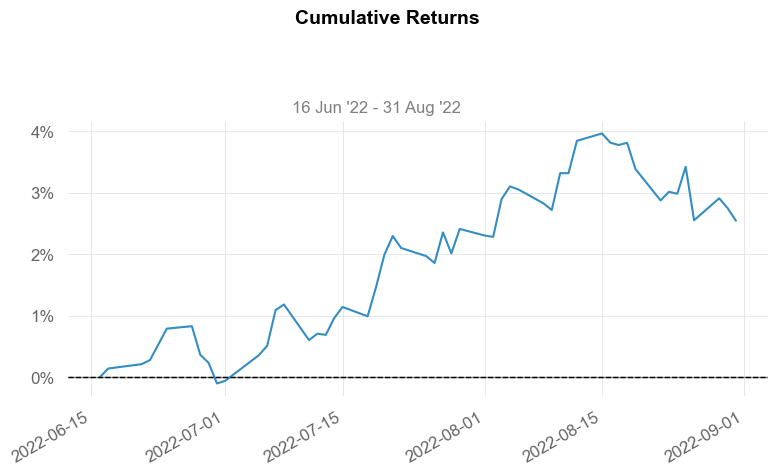

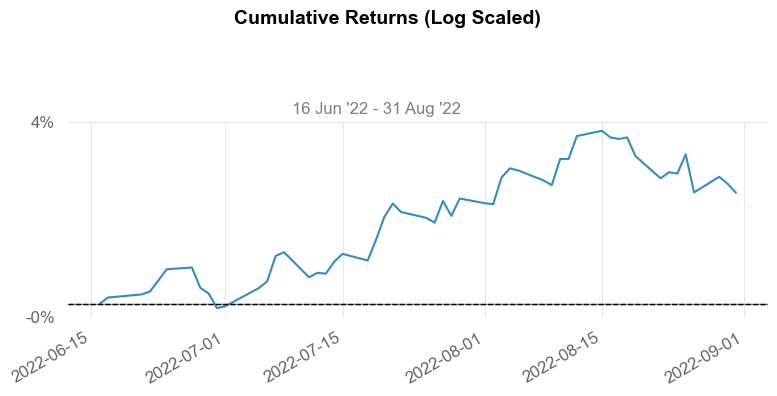

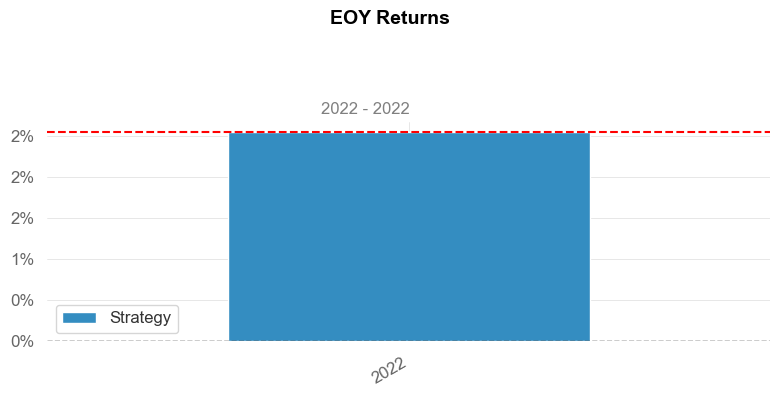

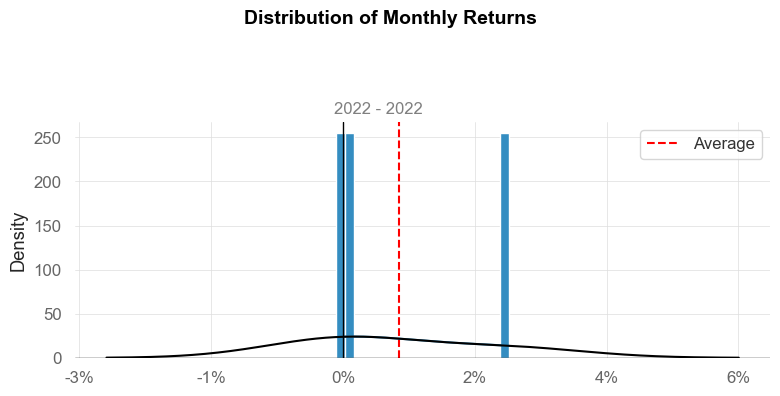

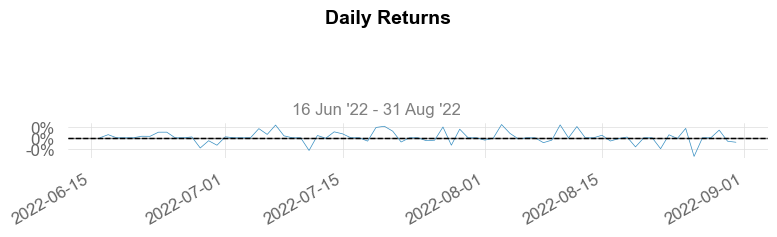

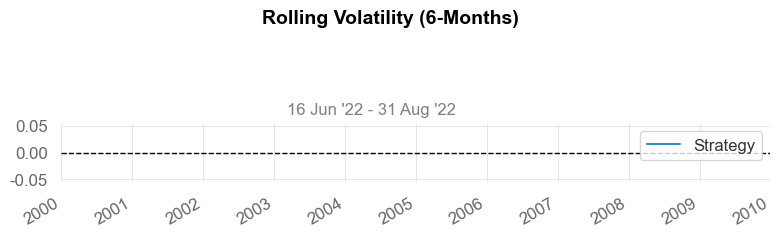

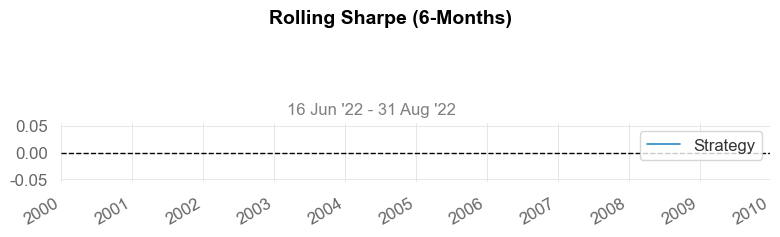

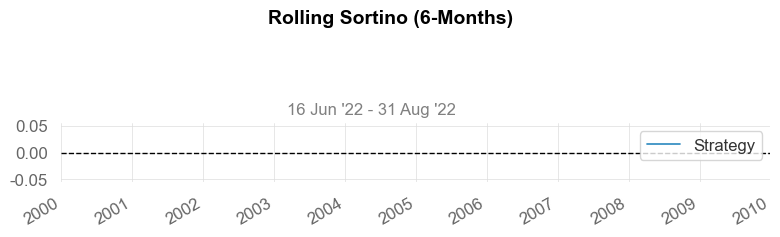

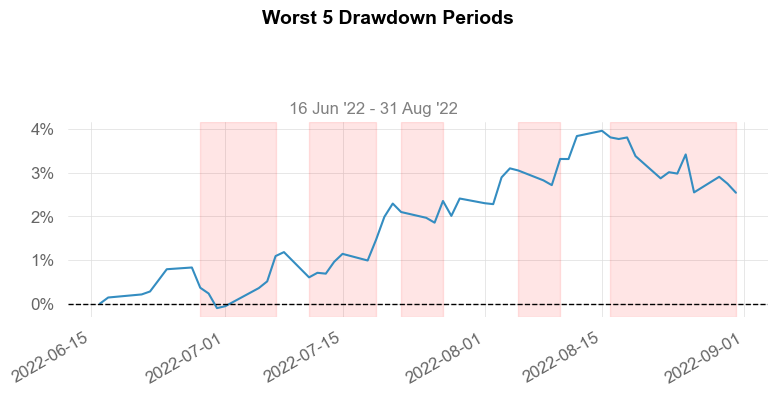

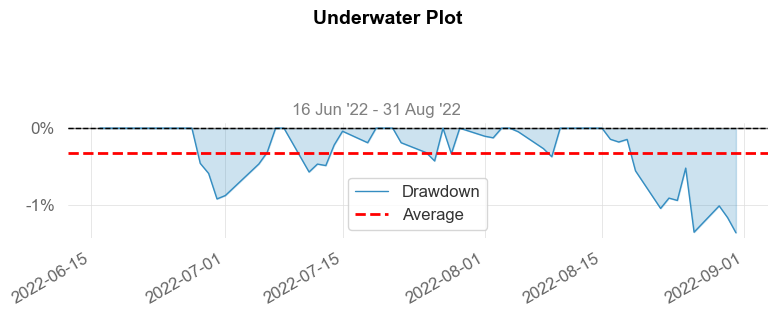

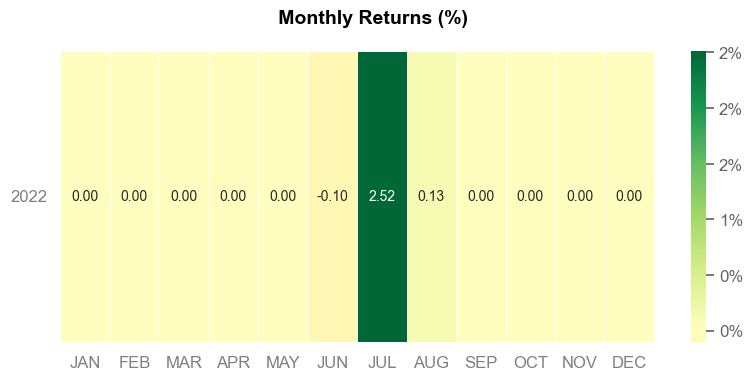

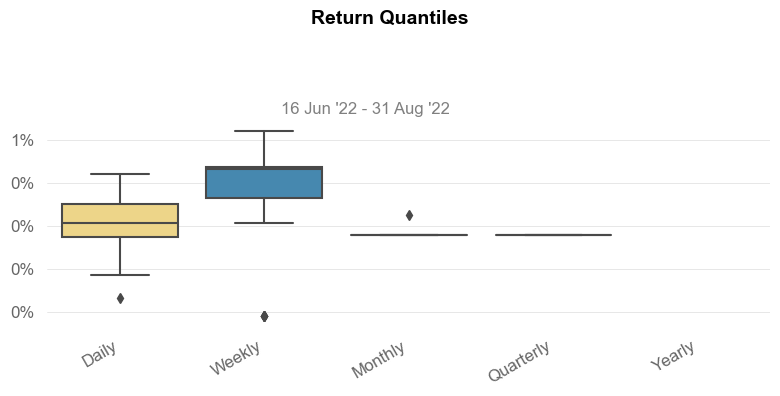

In [57]:
ModelwSentiment(tickers_to_predict=['TSLA'])

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1118/1552830259.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

initial weights
Index(['META', 'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM', 'META'],
      dtype='object')
betas.columns
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM', 'META'],
      dtype='object')
betas.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM'],
      dtype='object')
weights.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM'],
      dtype='object')
weights
                AAPL      MSFT      GOOG     GOOGL         V      NVDA  \
Date                                                    

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          1.99%
CAGR﹪                     9.9%

Sharpe                     1.35
Prob. Sharpe Ratio         73.79%
Smart Sharpe               1.25
Sortino                    2.13
Smart Sortino              1.98
Sortino/√2                 1.51
Smart Sortino/√2           1.4
Omega                      1.25

Max Drawdown               -1.58%
Longest DD Days            22
Volatility (ann.)          5.57%
Calmar                     6.28
Skew                       0.16
Kurtosis                   0.33

Expected Daily %           0.04%
Expected Monthly %         0.66%
Expected Yearly %          1.99%
Kelly Criterion            13.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.54%
Expected Shortfall (cVaR)  -0.54%

Max Consecutive Wins       7
Max 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-26,2022-08-31,15,-1.577517,-1.560159
2,2022-07-22,2022-07-26,2022-08-02,11,-1.449669,-0.934868
3,2022-06-27,2022-07-01,2022-07-19,22,-1.002022,-0.873615
4,2022-08-05,2022-08-09,2022-08-10,5,-0.450513,-0.089158
5,2022-06-17,2022-06-17,2022-06-21,4,-0.150508,0.000000


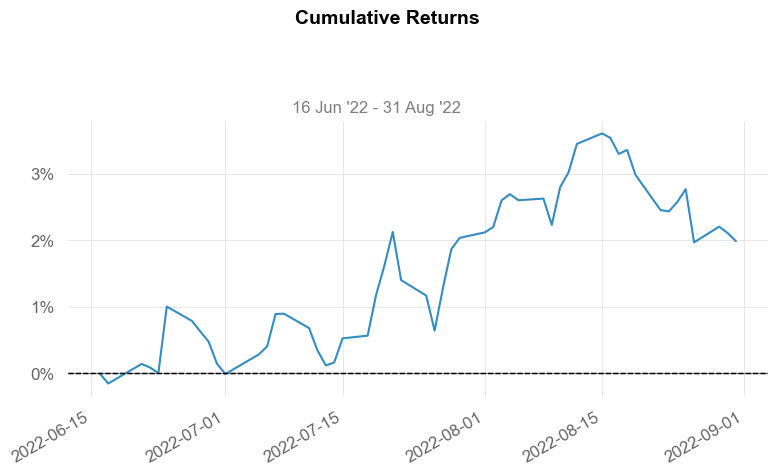

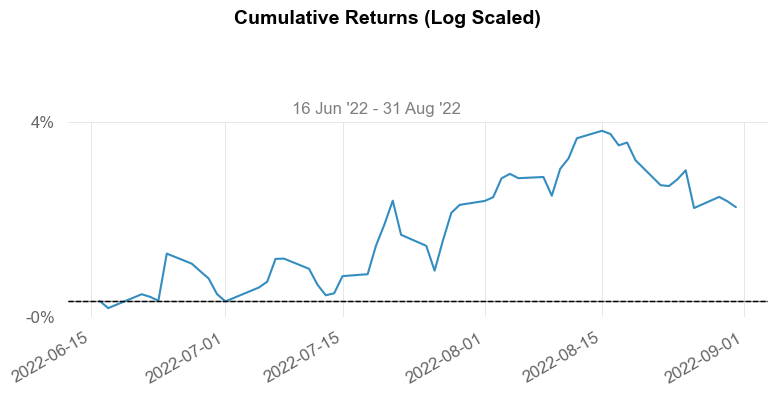

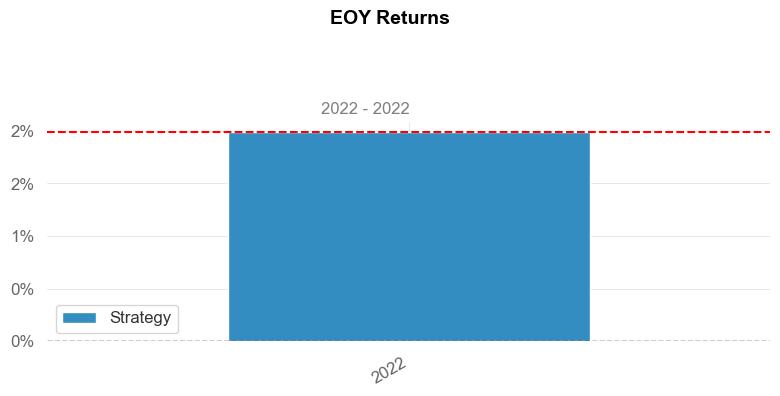

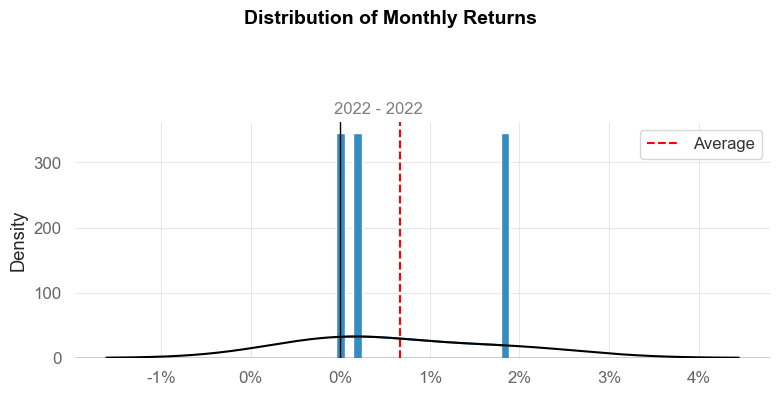

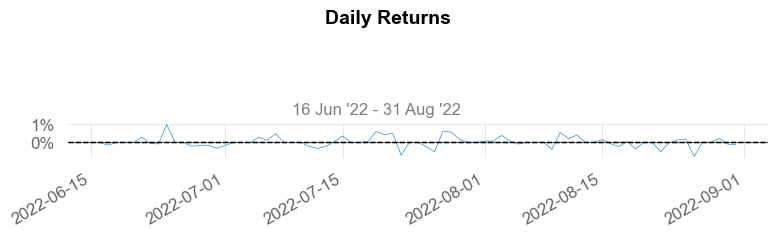

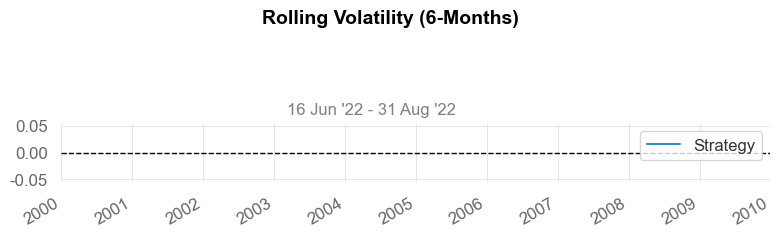

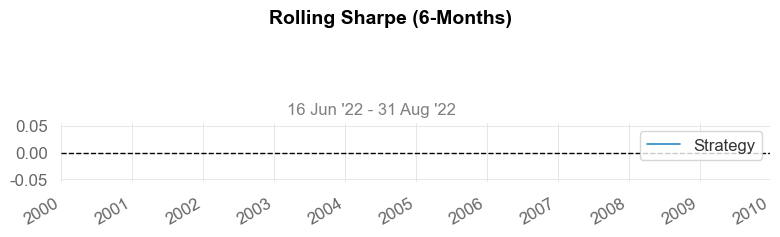

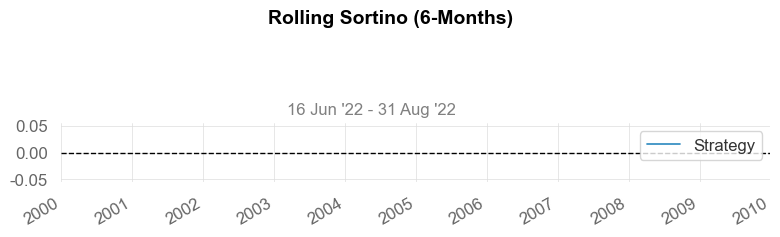

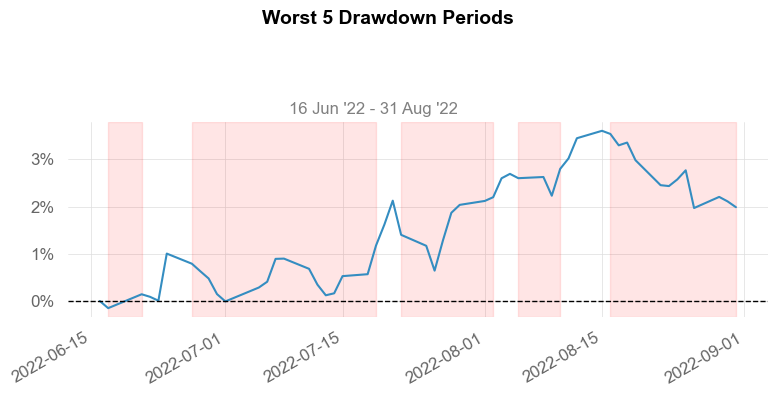

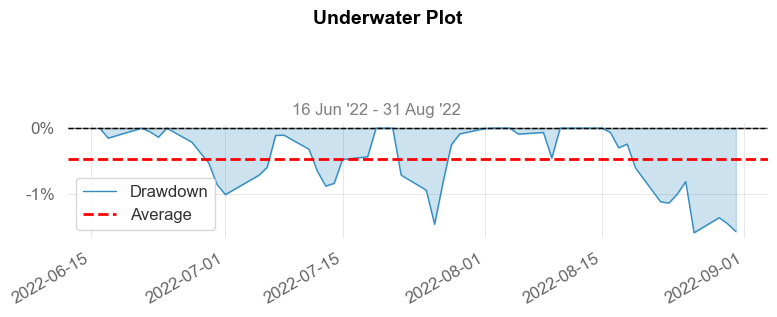

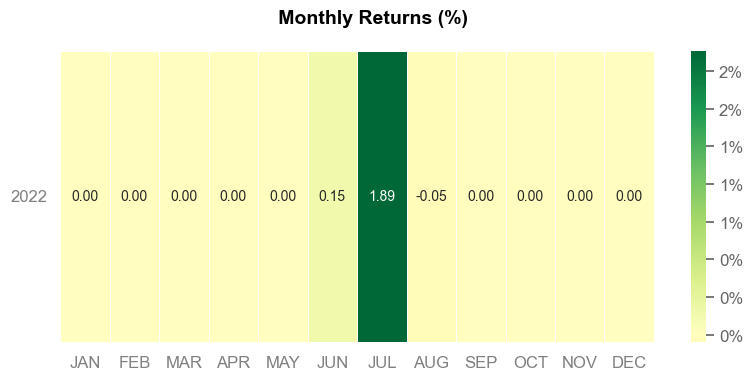

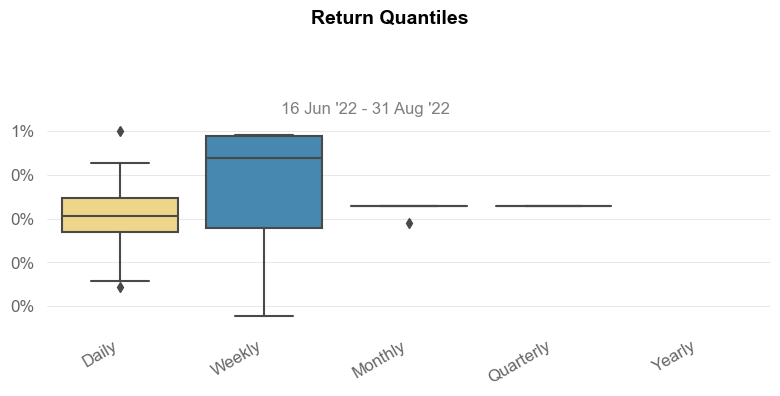

In [50]:
ModelwSentiment(tickers_to_predict=['META'])